## Libraries & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn  import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, SVMSMOTE  
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

random_state=42

##  Dataset

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [ ]:
# dataset with social economic features
df_new = pd.read_csv('bank-additional-full.csv', sep = ';')
df_new.head(3)

In [3]:
# get categorical data
categorical_features = df.select_dtypes(include=['object'])
#categorical_features

In [4]:
# get numerical data
Numeric_data = df.select_dtypes(include='number')
#Numeric_data

- Isolate the features and the target values.

- The target variable(y) is the last column in the Data Frame and hence using slicing, can separate them into feature and label.

In [5]:
# get all categorical feature except target vale y(deposit)
feature = categorical_features.iloc[:,:-1].values

In [6]:
label = categorical_features.iloc[:,-1].values
#label

### Correlation Matrix of the Numerical Features:

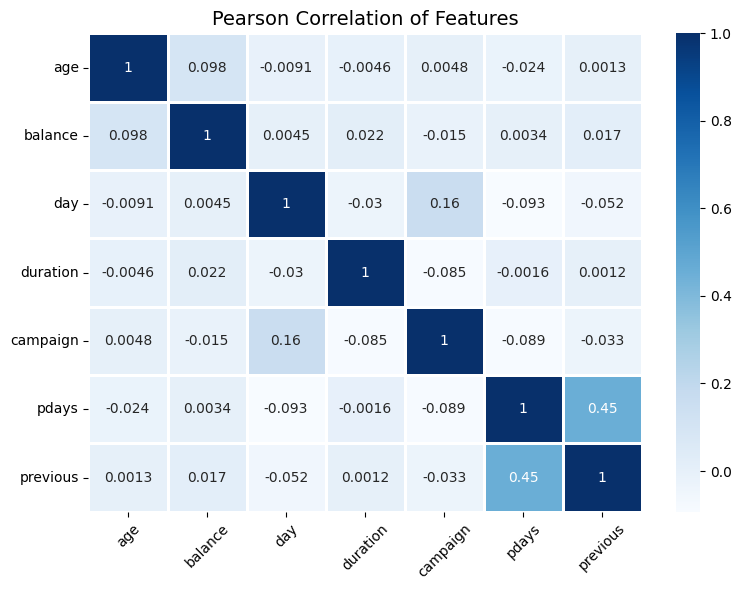

In [7]:
corr = df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), cmap='Blues', annot=True, square=False, linewidth=1, xticklabels=corr.columns, yticklabels=corr.columns, annot_kws={"size": 10}, ax=ax)
ax.set_title('Pearson Correlation of Features', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
fig.tight_layout()

**Observation**

- it seems **no** feature is heavily correlated with other features

## Imbalanced target value

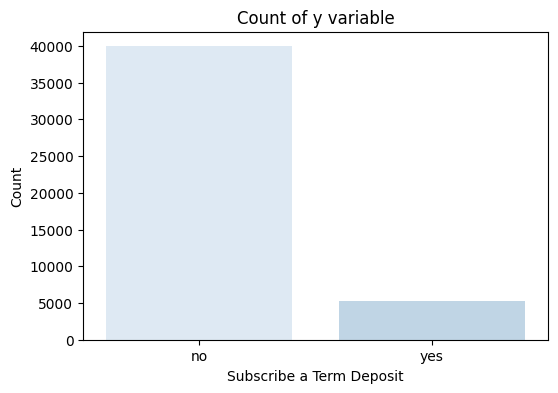

In [8]:
# set the color palette
sns.set_palette("Blues")

# plot the countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title("Count of y variable")
plt.xlabel("Subscribe a Term Deposit")
plt.ylabel("Count")
plt.show()

#  Pre_processing

### Drop Unnecessary Columns 

In [9]:
# According to EDA, some features like day,month have no affect on subscribition

df.drop(['day', 'month'], axis=1, inplace=True) 

- There are no missing values in this dataset. However, there are values labeled as unknown, which can be considered similar to missing values.



- The unknown values for the job and education columns are randomly distributed throughout those columns, indicating that they were not recorded or were otherwise unavailable. In this case, we may want to consider treating these unknown values as missing and imputing them using a suitable imputation method.



- The unknown values for the poutcome column represent the outcome of the previous marketing campaign for customers who were not previously contacted. To handle these values, we could segment the entire column into two categories: success and not success, based on whether the previous marketing campaign was successful or not. This would allow us to retain the information in the poutcome column without introducing missing values into the dataset.

    
- Overall, it is important to carefully consider the treatment of unknown values and missing values in the dataset to ensure that they do not bias the analysis or lead to inaccurate conclusions.

### Impute the Unknown Values

In [10]:
# Define the list of columns to impute
columns_to_impute = ['job', 'education']


# Loop over each column and impute unknown value
for i in columns_to_impute:
    # Compute the normalized value counts for non-unknown values
    value_counts = df.loc[df[i] != 'unknown', i].value_counts(normalize=True)
    df.loc[df[i] == 'unknown', i] = np.random.choice(value_counts.index, 
                                                       p = value_counts.values, size = df.loc[df[i]  == 'unknown'].shape[0] )

In [11]:
# 'unknown', 'failure', and 'other' indicate a lack of success in the previous marketing campaign
# We are replacing these values with 'not success' to simplify the analysis
# Note that the 'success' values are retained as-is
df['poutcome'] = df['poutcome'].replace({'unknown':'not success', 'failure':'not success', 'other':'not success'})

# Check the unique values in the original column
print(df['poutcome'].unique())

['not success' 'success']


### Transforem some Columns

In [12]:
df = df.rename(columns={'y': 'deposit'}) # Rename the target value
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0}) # Define new columns for deposit yes and no

df['duration'] = df['duration'].apply(lambda n: n / 60).round(2) #Change the unit of 'duration' from sec to min

# Encoding

-  According to litreature in the case of imbalanced data, using label encoding could result in an unintended bias towards the majority class. 


- This is because the numerical values assigned to each category may cause the model to treat the majority class as more important than the minority class. On the other hand, using dummy encoding could result in a more balanced representation of the categories, but it may also increase the risk of overfitting to the minority class.


-  However, I try both methods and  got slightly better results on dummy than label encoding.

### Dummy Encoding the Categorical Feature

In [13]:
#Convert categorical variables to dummy variables
df_dummy = pd.get_dummies(df[['job', 'marital', 'education', 'poutcome', 'contact']])

# Drop original categorical columns
df = df.drop(['job', 'marital', 'education', 'poutcome', 'contact'], axis=1)

#First Convert the object to Boolean
df['housing'] = df['housing'].astype(bool)
df['loan'] = df['loan'].astype(bool)
df['default'] = df['default'].astype(bool)

#Convert Boolean variables to integers
df['housing'] = df['housing'].astype('int')
df['loan'] = df['loan'].astype('int')
df['default'] = df['default'].astype('int')

# Concatenate encoded categorical variables with numerical variables
df = pd.concat([df_dummy, df], axis=1)

#Check the first few rows of the new DataFrame
df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_not success,poutcome_success,contact_cellular,contact_telephone,contact_unknown,age,default,balance,housing,loan,duration,campaign,pdays,previous,deposit
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,58,1,2143,1,1,4.35,1,-1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,44,1,29,1,1,2.52,1,-1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,33,1,2,1,1,1.27,1,-1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,47,1,1506,1,1,1.53,1,-1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,33,1,1,1,1,3.30,1,-1,0,0


#  Prepare the features and target variable

In [14]:
X = df.drop('deposit',axis=1)
y = df['deposit']

In [15]:
X.shape, y.shape

((45211, 31), (45211,))

# Feature Scaling

In [16]:
#Normalize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_scaled = scaler.fit_transform(X)
columns = X.columns
X = pd.DataFrame(x_scaled, columns=columns)
#x_scaled contains the normalized features

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36168, 31), (36168,), (9043, 31), (9043,))

In [19]:
# create a splitter object
stratified = StratifiedShuffleSplit(n_splits=5,test_size=0.2, random_state=42) 

# Apply Oversampling & Undersampling to improve the misclassification

- Apply the Oversampling and Undersampling on the entire train set



- Then compare to the unresample test set to see how well generalized to unseen data.

## Tuned Logistic Regression with applying undersampling and oversampling methods

In [21]:
# Define logistic regression model
lr_cv = LogisticRegression(random_state=42)

# Define the range of class weights
class_weights = [{0: 1, 1: w} for w in [3, 5, 7, 10, 12]] 

# Define hyperparameters to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'class_weight': class_weights,
    'solver': ['liblinear']
}

# Define the resampling methods
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
sm = SMOTE(random_state=42)

# Define lists to store the results
accu = []
methods = []
conf_matrices = []

# Iterate over the resampling methods
for method in [rus, ros, sm]:
    
    # Apply the resampling method to the training data
    X_resampled, y_resampled = method.fit_resample(X_train, y_train)
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(lr_cv, param_grid, cv=stratified, scoring='f1_macro')
    
    # Fit grid search to training data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best estimator and score
    best_lr = grid_search.best_estimator_  
    best_score = grid_search.best_score_    
    
    # Evaluate the best estimator on the test data
    y_pred = best_lr.predict(X_test)
    test_score = f1_score(y_test, y_pred)   

    print(f"Best F1 score with {method.__class__.__name__}: {best_score}")
    print(f"Test F1 score with {method.__class__.__name__}: {test_score}")
    print('Tuned hyperparameters: (best parameters)', grid_search.best_params_)

    # Append the test results
    accu.append(best_lr.score(X_test, y_test))
    methods.append(method.__class__.__name__)
    print(f'Accuracy with {method.__class__.__name__}:', best_lr.score(X_test, y_test))
    
    # Compute the confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    print(f"Confusion matrix with {method.__class__.__name__}:\n{conf_matrix}\n")
    print(f"Classification report with {method.__class__.__name__}:\n{classification_report(y_test, y_pred)}\n")


Best F1 score with RandomUnderSampler: 0.7692253792628496
Test F1 score with RandomUnderSampler: 0.37783279375357076
Tuned hyperparameters: (best parameters) {'C': 1000.0, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy with RandomUnderSampler: 0.638726086475727
Confusion matrix with RandomUnderSampler:
[[4784 3201]
 [  66  992]]

Classification report with RandomUnderSampler:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      7985
           1       0.24      0.94      0.38      1058

    accuracy                           0.64      9043
   macro avg       0.61      0.77      0.56      9043
weighted avg       0.90      0.64      0.70      9043


Best F1 score with RandomOverSampler: 0.7584152922292982
Test F1 score with RandomOverSampler: 0.3738037155188591
Tuned hyperparameters: (best parameters) {'C': 10.0, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy with RandomOver

**Insight:**


- Three different resampling techniques (random under-sampling, random over-sampling, and SMOTE) are applied to the data to address the class imbalance problem.


- For each resampling technique, the best hyperparameters are identified and the resulting model is evaluated on the test set using F1 score, accuracy, confusion matrix, and classification report.


- The results show that while all three resampling techniques not improve the F1 score compared to the baseline, but improve the recall comapare to baseline (0.56) 


- However, even with SMOTE, the model's performance on the positive class is relatively poor, with a recall of only 0.93 and an F1 score of 0.39. This indicates that the model is still struggling to accurately predict customers who are likely to churn.




## Tuned KNN with applying undersampling and oversampling methods

In [26]:
## Define the resampling techniques
rus = RandomUnderSampler()
ros = RandomOverSampler()
smote = SMOTE()

# Apply random undersampling
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Apply random oversampling
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Create a k-NN classifier with class weights
knn_cv = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

## Define hyperparameters to search over
param_grid = {'n_neighbors': [3, 5, 7, 9],
              'algorithm': ['auto'],
              'weights': ['distance', 'uniform']}

# Create GridSearchCV object
grid_search = GridSearchCV(knn_cv, param_grid, cv=stratified, scoring='f1_macro',n_jobs=-1)

# Fit grid search to training data with random undersampling
grid_search.fit(X_train_rus, y_train_rus)
best_knn_rus = grid_search.best_estimator_

# Evaluate the best estimator on the test data with random undersampling
y_pred_rus = best_knn_rus.predict(X_test)
test_score_rus = f1_score(y_test, y_pred_rus)

# Print results for random undersampling
print("Results with random undersampling:")
print(f"Best F1 score: {grid_search.best_score_}")
print(f"Test F1 score: {test_score_rus}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred_rus)}")
print(f"Classification report:\n{classification_report(y_test, y_pred_rus)}")

# Fit grid search to training data with random oversampling
grid_search.fit(X_train_ros, y_train_ros)
best_knn_ros = grid_search.best_estimator_

# Evaluate the best estimator on the test data with random oversampling
y_pred_ros = best_knn_ros.predict(X_test)
test_score_ros = f1_score(y_test, y_pred_ros)

# Print results for random oversampling
print("Results with random oversampling:")
print(f"Best F1 score: {grid_search.best_score_}")
print(f"Test F1 score: {test_score_ros}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred_ros)}")
print(f"Classification report:\n{classification_report(y_test, y_pred_ros)}")

# Fit grid search to training data with SMOTE
grid_search.fit(X_train_smote, y_train_smote)
best_knn_smote = grid_search.best_estimator_

# Evaluate the best estimator on the test data with SMOTE
y_pred_smote = best_knn_smote.predict(X_test)
test_score_smote = f1_score(y_test, y_pred_smote)

# Print results for SMOTE
print("Results with SMOTE:")
print(f"Best F1 score: {grid_search.best_score_}")
print(f"Test F1 score: {test_score_smote}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred_smote)}")
print(f"Classification report:\n{classification_report(y_test, y_pred_ros)}")

Results with random undersampling:
Best F1 score: 0.7847348893883244
Test F1 score: 0.43731302692412305
Confusion matrix:
[[6170 1815]
 [ 254  804]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7985
           1       0.31      0.76      0.44      1058

    accuracy                           0.77      9043
   macro avg       0.63      0.77      0.65      9043
weighted avg       0.88      0.77      0.81      9043

Results with random oversampling:
Best F1 score: 0.924863524913891
Test F1 score: 0.4287890327494288
Confusion matrix:
[[6980 1005]
 [ 495  563]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7985
           1       0.36      0.53      0.43      1058

    accuracy                           0.83      9043
   macro avg       0.65      0.70      0.67      9043
weighted avg       0.87      0.83      0.85      9043

Resul

**Insight:**


- The goal of these techniques was to address the class imbalance problem in the dataset and improve the recall of the minority class.



- All three techniques improved the recall of the minority class compared to the baseline, which did not perform any resampling. This means that the techniques were successful in identifying more of the positive cases.



- However, none of the resampling techniques improved the overall F1 score compared to the baseline. This means that while the techniques improved the recall of the minority class, they did not do so without sacrificing precision or accuracy overall.



- In the case of KNN, this may be because the algorithm is not well-suited to handle imbalanced datasets. KNN is sensitive to differences in the distributions of the classes, and resampling may not be enough to address this issue.



- Overall, these results suggest that resampling techniques can be useful in addressing class imbalance in classification tasks, but they may not always result in improvements to overall model performance. The choice of technique and algorithm will depend on the specific dataset and problem at hand.

## Tuned Random Forest with applying undersampling and oversampling methods

In [27]:
# Define the random forest classifier 
rf_1 = RandomForestClassifier(random_state=42)

# Define the class_weight (gives equal importance to the classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_rf = [{0:class_weights[0],1:class_weights[1]}]

# Number of trees in random forest
n_estimators = [10, 30, 50, 70, 90]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 7, 9]

# Define the parameters for GridSearchCV
parameters = {'n_estimators': n_estimators, 
              'criterion' : ['entropy'], 
              'max_depth': max_depth, 
              'max_features': ['auto', 'sqrt'],
              'class_weight': class_weights_rf}

# Define the resampling techniques
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
rus = RandomUnderSampler()
ros = RandomOverSampler()
smote = SMOTE()

# Define the GridSearchCV object for RandomOverSampler
X_ros, y_ros = ros.fit_resample(X_train, y_train)
grid_search_ros = GridSearchCV(rf_1, parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)
grid_search_ros.fit(X_ros, y_ros)

# Get the best estimator and score
best_rf_ros = grid_search_ros.best_estimator_
best_score_ros = grid_search_ros.best_score_

# Evaluate the best estimator on the test data
y_pred_ros = best_rf_ros.predict(X_test)
test_score_ros = f1_score(y_test, y_pred_ros)

# Results ROS
print("Random Over Sampler (ROS) Results:")
print(f"Best F1 score: {best_score_ros}")
print(f"Test F1 score: {test_score_ros}")
print(f"Test accuracy: {best_rf_ros.score(X_test, y_test)}")
print(confusion_matrix(y_test, y_pred_ros))
print(classification_report(y_test, y_pred_ros))


# Define the GridSearchCV object for RandomUnderSampler
X_rus, y_rus = rus.fit_resample(X_train, y_train)
grid_search_rus = GridSearchCV(rf_1, parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)
grid_search_rus.fit(X_rus, y_rus)

# Get the best estimator and score
best_rf_rus = grid_search_rus.best_estimator_
best_score_rus = grid_search_rus.best_score_

#Evaluate the best estimator on the test data
y_pred_rus = best_rf_rus.predict(X_test)
test_score_rus = f1_score(y_test, y_pred_rus)

#Print RUS
print("Random Under Sampler (RUS) Results:")
print(f"Best F1 score: {best_score_rus}")
print(f"Test F1 score: {test_score_rus}")
print(f"Test accuracy: {best_rf_rus.score(X_test, y_test)}")
print(confusion_matrix(y_test, y_pred_rus))
print(classification_report(y_test, y_pred_rus))


# Define the GridSearchCV object for SMOTE


#Resample the training data using SMOTE
X_smote, y_smote = smote.fit_resample(X_train, y_train)

#Fit grid search to SMOTE resampled data
grid_search_smote = GridSearchCV(rf_1, parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)
grid_search_smote.fit(X_smote, y_smote)

# Get the best estimator and score
best_rf_smote = grid_search_smote.best_estimator_
best_score_smote = grid_search_smote.best_score_

#Evaluate the best estimator on the test data
y_pred_smote = best_rf_smote.predict(X_test)
test_score_smote = f1_score(y_test, y_pred_smote)

# print smote 
print("SMOTE Results:")
print(f"Best F1 score: {best_score_smote}")
print(f"Test F1 score: {test_score_smote}")
print(f"Test accuracy: {best_rf_smote.score(X_test, y_test)}")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

Random Over Sampler (ROS) Results:
Best F1 score: 0.6783638306048437
Test F1 score: 0.3076695291679005
Test accuracy: 0.48291496184894395
[[3328 4657]
 [  19 1039]]
              precision    recall  f1-score   support

           0       0.99      0.42      0.59      7985
           1       0.18      0.98      0.31      1058

    accuracy                           0.48      9043
   macro avg       0.59      0.70      0.45      9043
weighted avg       0.90      0.48      0.55      9043

Random Under Sampler (RUS) Results:
Best F1 score: 0.6960121155951355
Test F1 score: 0.31252833610397457
Test accuracy: 0.49695897379188325
[[3460 4525]
 [  24 1034]]
              precision    recall  f1-score   support

           0       0.99      0.43      0.60      7985
           1       0.19      0.98      0.31      1058

    accuracy                           0.50      9043
   macro avg       0.59      0.71      0.46      9043
weighted avg       0.90      0.50      0.57      9043

SMOTE Results:

**Insight:**


- Resampling techniques did not improve the performance of the model in terms of F1-score, recall, and test accuracy.


- The best F1-score and recall were obtained without any resampling technique applied.(baseline without resampling)


- The class imbalance in this dataset is quite severe, with the minority class only accounting for about 12% of the data.


- More advanced techniques such as ensemble learning or deep learning may be necessary for better performance in such cases.

# Model Effectivness


## ROC Curve (Receiver Operating Curve) & AUC

- The ROC curve tells us how well our classifier is classifying between term deposit suscriptions (True Positives) and non-term deposit suscriptions. 


- The X-axis is represented by False positive rates (Specificity) and the Y-axis is represented by the True Positive Rate (Sensitivity.) 


- As the line moves the threshold of the classification changes giving us different values. The closer is the line to our top left corner the better is our model separating both classes.

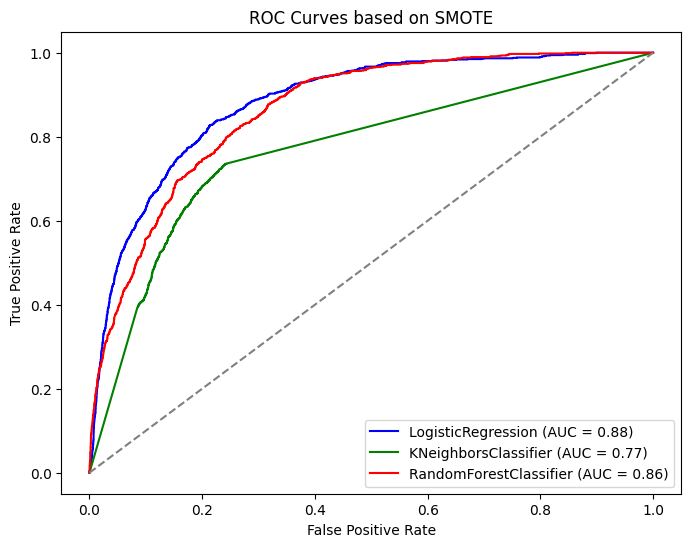

In [34]:
from sklearn.metrics import RocCurveDisplay


# Define color palette
colors = ['blue', 'green', 'red']

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for each model with a different color
for i, estimator in enumerate([best_lr, best_knn_smote, best_rf_smote]):
    RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=ax, name=estimator.__class__.__name__, color=colors[i])

# Plot the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add axis labels and a title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves based on SMOTE')

# Add a legend
ax.legend()

# Conclusion:

- Resampling techniques were applied to logistic regression and KNN models to address class imbalance in the dataset. 



- While the techniques improved the recall of the minority class, they did not always result in overall performance improvements. 



- The random forest model did not benefit from resampling, and more advanced techniques may be necessary for severe class imbalances. 